In [60]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import tensorflow as tf
import pandas as pd
import os
import sys
import numpy as np
sys.path.append("../../Code")
import utils
import files as f
import seaborn as sns
import matplotlib.pyplot as plt
stopWords = set(stopwords.words('english'))

In [2]:
vocab_reviews = pd.read_csv(os.path.join('..','2','len_lang_restrict_reviews.csv'), index_col=0)
vocab_guests = pd.read_csv(os.path.join('..','2','len_lang_restrict_guests.csv'), index_col=0)
vocab_hosts = pd.read_csv(os.path.join('..','2','len_lang_restrict_hosts.csv'), index_col=0)
vocab_guests['id'] = vocab_guests['id'].astype(str)

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
def pipeline(data, col, stopwords=[], vocab=None):
    data_encoded = {}
    vocab_counts = {}
    vocab_doc_count = {}

    is_ext_vocab = True
    if vocab is None:
        is_ext_vocab = False
        vocab = {'<OOV>': 0}
        vocab_counts['<OOV>'] = 0
    for _,d in data.iterrows():
        r = []
        doc_vocab = set()
        tokenized_r = utils.tokenize(d[col])
        for token in tokenized_r:
            #token = ps.stem(token)
            if token.lower() in stopwords:
                continue
            if not is_ext_vocab and token not in vocab:
                vocab[token] = len(vocab)
                vocab_counts[token] = 1
                doc_vocab.add(token)
                vocab_doc_count[token] = 1
            if token not in vocab:
                token_id = vocab['<OOV>']
                vocab_counts['<OOV>'] += 1
            elif token not in doc_vocab:
                doc_vocab.add(token)
                vocab_doc_count[token] = 1 if token not in vocab_doc_count.keys() else vocab_doc_count[token] + 1
                token_id = vocab[token]
                vocab_counts[token] += 1
            else:
                token_id = vocab[token]
                vocab_counts[token] += 1
            r.append(token_id)
        data_encoded[d['id']] = r
    N = len(data)
    idf_dict = []
    for key in vocab.keys():
        if key in vocab_doc_count.keys():
            idf_dict.append(np.log10(N/vocab_doc_count[key]))
        else:
            idf_dict.append(0)
    return (data_encoded, vocab_counts, vocab, idf_dict)

In [27]:
data = pd.concat([vocab_guests[['id', 'description']], vocab_hosts[['id', 'about']].rename(columns={'about': 'description'})]).reset_index()

In [28]:
len(data)

114019

In [29]:
data = data.drop_duplicates()

In [30]:
data = data[~data.description.isnull()]

# Create Vocabulary 

In [31]:
profiles_encoded, vocab_count, vocab, idf = pipeline(data, 'description', stopWords)

In [32]:
def create_vocab_count_table(counts):
    return pd.DataFrame({'counts':[counts[k] for k in counts.keys()], 'word':[k for k in counts.keys()]})

In [33]:
vocab_table = create_vocab_count_table(vocab_count)

# Word 2Vec

In [14]:
from gensim.models.keyedvectors import KeyedVectors
# should load in 2 min
w2v = KeyedVectors.load_word2vec_format('../../Tools/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [16]:
w2v.similarity('Reserve', 'reserve')
# notice how word2vec is case sensitive!!

0.5967262848366335

In [21]:
vocab_count["travelling"]

4657

#### Asses which words are in the model

In [34]:
known_words = []
unknown_words = []

for word in vocab.keys():
    try:
        _ = w2v[word]
        known_words.append(word)
    except:
        unknown_words.append(word)

In [35]:
print("in: ", len(known_words), "out: ", len(unknown_words))

in:  45667 out:  16620


In [36]:
unknown_words[0:15]

['<OOV>',
 '41',
 'soundengineer',
 'citylife',
 'Jarmush',
 'Ghostdog',
 'Cannot',
 '27',
 'travelling',
 'favourite',
 'Grünerløkka',
 'amante',
 'viajes',
 'Permite',
 'realidades']

# Look at Unknown Words 

In [40]:
unknown_table = pd.DataFrame({'unknown_word': unknown_words, 'vocab_count': [vocab_count[word] for word in unknown_words]})

In [46]:
unknown_w = unknown_table[~unknown_table['unknown_word'].str.isnumeric()].sort_values(by="vocab_count", ascending=False)

In [47]:
unknown_n = unknown_table[unknown_table['unknown_word'].str.isnumeric()].sort_values(by="vocab_count", ascending=False)

In [49]:
unknown_w.head()

,unknown_word,vocab_count
8,travelling,4657
51,airbnb,1515
201,theatre,921
91,travelled,792
9,favourite,773


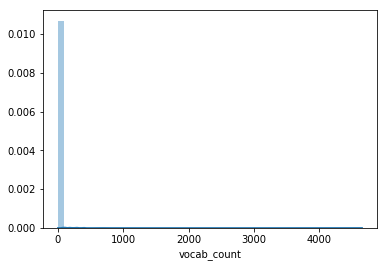

In [50]:
sns.distplot(unknown_table['vocab_count'])
plt.show()

#### Set up embeddings 

In [100]:
sys.path.append("../../Tools/np-to-tf-embeddings-visualiser-master")
from save_embeddings import save_embeddings

In [110]:
N = len(vocab.keys())
L = 300
my_embeddings = np.zeros((N, L))

In [111]:
for word, ID in vocab.items():
    try:
        my_embeddings[ID] = w2v[word]
    except:
        # if no embedding, leave as all zeros
        pass

In [83]:
np.save('./airbnb', my_embeddings)

In [94]:
my_word_embeddings = np.load('airbnb.npy')

In [119]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector

# setup a TensorFlow session
tf.reset_default_graph()
sess = tf.InteractiveSession()
X = tf.Variable([0.0], name='embedding')
place = tf.placeholder(tf.float32, shape=my_embeddings.shape)
set_x = tf.assign(X, place, validate_shape=False)
sess.run(tf.global_variables_initializer())
sess.run(set_x, feed_dict={place: my_embeddings})

# write labels
with open('log/metadata.tsv', 'w') as f:
    for word,_ in vocab.items():
        f.write(word + '\n')

# create a TensorFlow summary writer
summary_writer = tf.summary.FileWriter('log', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('log', 'metadata.tsv')
projector.visualize_embeddings(summary_writer, config)

# save the model
saver = tf.train.Saver()
saver.save(sess, os.path.join('log', "model.ckpt"))

'log/model.ckpt'